In [1]:
%matplotlib inline

# DISPERSION ANALYSIS II
Author: Jordan Guerra (for Villanova University). May 2024.

This tutorial illustrates the more advanced use of the package *polBpy* for performing angular dispersion analysis and studying the magnetoturbulent state of gas using dust polarimetric observations. Parameters determined with this anaylsis can be used for DCF calculations.

This tutorial uses data from literature listed [here.](https://github.com/jorgueagui/polBpy/blob/9039d4af5d25c49130bf51be7fe0ce363424edcc/refs.md)

**EXAMPLE I**: This example shows how to perform local dispersion analysis for a region of dust/gas. This analysis follows these steps: 1) calculating the autocorrelation function of the polarized flux, and measuring its width as estimation of the cloud's depth; 2) calculating a pixel-by-pixel *dispersion function* by defining a circular kernel of radius $w$ centered at each pixel; 3) fitting the *dispersion functions* with the two-scale model of Houde+09 using a Markov-Chain Montecarlo (MCMC) approach and determining the magnetotubrulent parameters. We reproduce here some results from Guerra+21, which presents uses SOFIA/HAWC+ multiwavelength polarimetric observations of the OMC-1 region.

In [58]:
from polBpy import dispersion, fitting, utils
import numpy as np
import matplotlib.pyplot as plt
import emcee

In this example we try to reproduce resukts from Guerra+21. Specifically, reproducing the plots in Figure 3, which utilizes the 214 $\mu$m data. First, we load all the necessary data

In [59]:
from astropy.io import fits
import os
#cdir = os.path.dirname(os.getcwd())
file = 'Merged_Full_Polarization_Rotated.fits'
data = fits.open(file)
print(data.info())

Filename: Merged_Full_Polarization_Rotated.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  STOKES I      1 PrimaryHDU    1490   (1900, 950)   float64   
  1  ERROR I       1 ImageHDU        19   (1900, 950)   float64   
  2  STOKES Q      1 ImageHDU        19   (1900, 950)   float64   
  3  ERROR Q       1 ImageHDU        19   (1900, 950)   float64   
  4  STOKES U      1 ImageHDU        19   (1900, 950)   float64   
  5  ERROR U       1 ImageHDU        19   (1900, 950)   float64   
  6  IMAGE MASK    1 ImageHDU        60   (1900, 950)   float64   
  7  PERCENT POL    1 ImageHDU        19   (1900, 950)   float64   
  8  DEBIASED PERCENT POL    1 ImageHDU        19   (1900, 950)   float64   
  9  ERROR PERCENT POL    1 ImageHDU        19   (1900, 950)   float64   
 10  POL ANGLE     1 ImageHDU        19   (1900, 950)   float64   
 11  ROTATED POL ANGLE    1 ImageHDU        19   (1900, 950)   float64   
 12  ERROR POL ANGLE    1 ImageHDU        19   (1900, 950)   

and exclude all pixels with $p/p_{err}$ > 3.0 as done in Tutorial III

In [60]:
p_flux = data['DEBIASED POL FLUX'].data # 
p_flux = p_flux[588:656, 994:1066]
p_flux_err = data['ERROR POL FLUX'].data #
p_flux_err = p_flux_err[588:656, 994:1066]
pixel_size = data[0].header['CDELT2']*3600 #in arcsec
# Find the points
m = np.where((p_flux/p_flux_err > 3.0))# & (p_flux<.5))
# Create the mask
mask = np.full_like(p_flux,0.0)
mask[m] = 1.0

Step 1: calculating $\Delta^{\prime}$ through the autocorrelation function. We call the autocorrelation function (for further details on this function see Tutorial III),

In [61]:
Delta_p, Delta_p_err = dispersion.autocorrelation(p_flux,p_flux_err,pixsize=pixel_size,mask=mask,plots=False,hwhm=True)

And print the $\Delta^{\prime}$ in the (multiple of) units of pixel_size (arcsec in this case)

In [62]:
print("Delta' = %2.2f +/- %2.2f [arcmin]"%(Delta_p,Delta_p_err))

Delta' = 1.38 +/- 0.11 [arcmin]


Step 2: calcualting the *dispersion function map*. In order to calculate the map of *dispersion functions*, we need to define the relevant variables, including the beam size, and the size of the circular kernel in pixel. Following Guerra+21 we define $w$=9 pixels

In [63]:
angles = data['ROTATED POL ANGLE'].data # 
angles = angles[588:656, 994:1066]
angles_err = data['ERROR POL ANGLE'].data #
angles_err = angles_err[588:656, 994:1066]
beam_s = 4*pixel_size # FWHM value of the beam
win_s = 9 # pixel

Similarly to *dispersion_function*, *dispersion_function_map* takes the polarization angles, their errors, pixel size, beam, mask, and the kernel size. In addition, you can use the keyword *verb* to printout progress of the calculation. However, the larger the size of the area to process, printing out progress can significantly slow down the process. *verb=False* only prints out which pixels are not processed.

In [64]:
res1 = dispersion.dispersion_function_map(angles,angles_err,pixel_size,mask=mask,beam=beam_s,w=win_s,verb=False)

Analysis window size =  19 x 19


C:\Users\nora7\anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\nora7\anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\nora7\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nora7\anaconda3\lib\site-packages\polBpy\utils.py:113: RuntimeWarning: Mean of empty slice
  rms = np.sqrt(np.nanmean(vec**2))


Skipping Pixel = 9 30
Skipping Pixel = 9 31
Skipping Pixel = 9 32
Skipping Pixel = 10 30
Skipping Pixel = 10 31
Skipping Pixel = 10 32
Skipping Pixel = 11 30
Skipping Pixel = 11 31
Skipping Pixel = 11 32
Skipping Pixel = 12 30
Skipping Pixel = 12 31
Skipping Pixel = 12 32
Skipping Pixel = 13 30
Skipping Pixel = 13 31
Skipping Pixel = 13 32


C:\Users\nora7\anaconda3\lib\site-packages\polBpy\dispersion.py:159: RuntimeWarning: invalid value encountered in sqrt
  errors_c[i]= np.sqrt( (sinDphisum[i]**2)*sigma2sum[i] + (sinDphisum[i]**2)*Dphisum[i] + \


Skipping Pixel = 14 31
Skipping Pixel = 14 32
Skipping Pixel = 14 33
Skipping Pixel = 15 31
Skipping Pixel = 15 32
Skipping Pixel = 15 33
Skipping Pixel = 16 31
Skipping Pixel = 16 32
Skipping Pixel = 16 33
Skipping Pixel = 16 34
Skipping Pixel = 17 32
Skipping Pixel = 17 33
Skipping Pixel = 17 34
Skipping Pixel = 18 32
Skipping Pixel = 18 33
Skipping Pixel = 18 34
Skipping Pixel = 18 61
Skipping Pixel = 18 62
Skipping Pixel = 19 32
Skipping Pixel = 19 33
Skipping Pixel = 19 34
Skipping Pixel = 19 62
Skipping Pixel = 20 32
Skipping Pixel = 20 33
Skipping Pixel = 20 34
Skipping Pixel = 21 31
Skipping Pixel = 21 32
Skipping Pixel = 21 33
Skipping Pixel = 21 34
Skipping Pixel = 21 39
Skipping Pixel = 21 40
Skipping Pixel = 21 41
Skipping Pixel = 22 32
Skipping Pixel = 22 33
Skipping Pixel = 22 34
Skipping Pixel = 22 35
Skipping Pixel = 22 38
Skipping Pixel = 22 39
Skipping Pixel = 22 40
Skipping Pixel = 23 32
Skipping Pixel = 23 33
Skipping Pixel = 23 34
Skipping Pixel = 23 35
Skipping Pi

For sanity check, let us visualize one dispersion function. We choose a pixel towards the center of the image

Text(0, 0.5, '$1-\\langle \\cos(\\Delta\\phi)\\rangle$')

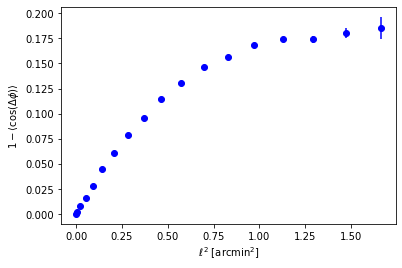

In [65]:
epix = (32,32) # Example pixel
lvec = res1[0][epix]/3600. # \ell^2 values
disp_f = res1[1][epix] # Dispersion function
disp_f_err = res1[2][epix] # Dispersion errors
plt.errorbar(lvec,disp_f,yerr=disp_f_err,fmt='bo')
plt.xlabel(r'$\ell^{2}$ [arcmin$^{2}$]')
plt.ylabel(r'$1-\langle \cos(\Delta\phi)\rangle$')

This *dispersion function* looks reasonable since we can see a fairly linear regime for $\sim$0.125-1 arcmin$^{2}$. 
Step 3: fitting the *dispersion functions*. This is step is similar to that of Tutorial III, in which we fitted one function using the MCMC fitter. Here, such approach is applied to every pixel with a valid *dispersion function*. From such fits we determine the maps of paremeters. To accelerate this process, we only fit a subregion of the entire 214 $\mu$m data,

In [67]:
m_lvec = res1[0][12:42,12:42,:] # in arcsec^2 (20 x 20 pixels region around the example pixel)
m_disp_f = res1[1][12:42,12:42,:] # dispersion function (sub)map
m_disp_f_err = res1[2][12:42,12:42,:] # dispersion errors (sub)map

The function *mcmc_fit_map* uses several more keywords than *mcmc_fit* since it is implemented in a way that can be parallelized. That is, fitting processes corresponding to different pixels can be sent to different cores (this process does not require communication between the different processes). Besdides the necessary inputs (dispersion function map, their uncertainties, $\ell$ values, kernel size (in pixels), beam size (in arcsecs), we can provide initial-guess values for the parameters $a_{2}$, $\delta$, and $\Delta^{\prime}/[\langle B_{t}^{2}\rangle/\langle B_{0}^{2}\rangle]$. Keyword *num* sets the number of random walkers and iterations for the MCMC fittting and its default value is 500. Keyword *n_cores* allows you to select the number of cores/processes to be executed and its default value (*n_cores=False*) is half of available cores.

In [20]:
res2 = fitting.mcmc_fit_map(m_disp_f,m_lvec,m_disp_f_err,win_s,pixel_size,beam=beam_s,a2=1.0E-3,delta=30.,f=100.,
                            num=200,verb=False,n_cores=False)

Running MCMC fitting in 4 cores


The output of *mcmc_fit_map* is a dictionary with maps of all three parameters mentioned above, plus maps of goodness-of-fit $\chi$ and non-linear rank correlation coefficient $\rho$.

Let us inspect the fit for the example pixel plotted above,

In [68]:
l = np.arange(0,10000) # define some values of \ell^2 in arcsec for the model
# Choose the same pixel example
# Evaluate the two-scale function
nepix = (10,10) # since it will correspond to epix in our sub-array
a2 = res2['a'][nepix]# arcsec^-2
delta = res2['d'][nepix] # arcsec
ratio = res2['f'][nepix] # arcsec
f = fitting.model_funct(l,a2,delta,ratio,beam=beam_s)

Replot the dispersion function and fit,

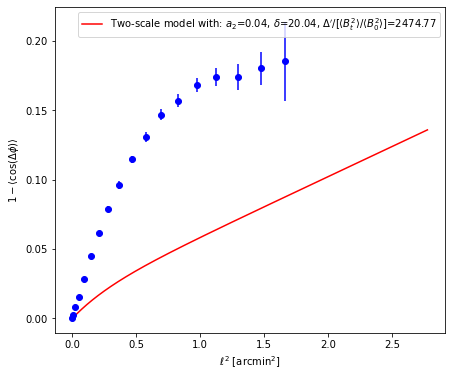

In [69]:
lvec = res1[0][epix]/3600.
disp_f = res1[1][epix]
disp_f_err = res1[2][epix]
plt.figure(figsize=(7,6))
plt.errorbar(lvec,disp_f,yerr=res2['chi'][10,10]*disp_f_err,fmt='bo')
plt.xlabel(r'$\ell^{2}$ [arcmin$^{2}$]')
plt.ylabel(r'$1-\langle \cos(\Delta\phi)\rangle$')
lratio = r'$\Delta^{\prime}/[\langle B_{t}^{2}\rangle/\langle B_{0}^{2}\rangle]$'
label = r'Two-scale model with: $a_{2}$=%2.2f, $\delta$=%2.2f, %s=%2.2f'%(a2*3600.,delta,lratio,ratio)
plt.plot(l/3600., f,c='red',label=label)
# plt.ylim([0.,0.05])
# plt.xlim([0.,1.5])
plt.legend()

We can see from this plot that the MCMC solver finds parameter values that describe the data well. Better parameters can be obtained by giving *mcmc_fit_map* different initial-guess values or a larger number of walker/iterations. Good initial-guess values are those obtained by the dispersion analysis performed to the entire region, such as described in Tutorial III.

For consistency to values reported in Guerra+21, we print the parameters fro this fit

In [70]:
a2 = res2['a'][nepix]*3600.*1000 # Units of 10^{-3} arcmin^{-2}
print("a_2 = %2.3E [arcmin^-2]"%a2)

a_2 = 4.340E+01 [arcmin^-2]


In [71]:
print("delta = %2.2f [arcsec]"%delta)

delta = 20.04 [arcsec]


In [72]:
Delta_p *= 60. # Cloud's depth in arcsec
ratio = Delta_p/res2['f'][nepix]
print("ratio = %2.2f"%ratio)

ratio = 0.03


We can now visualize the maps of parameters calculated,

Text(0.5, 1.0, '$\\langle B_{t}^{2}\\rangle/\\langle B_{0}^{2}\\rangle$')

<Figure size 1440x360 with 0 Axes>

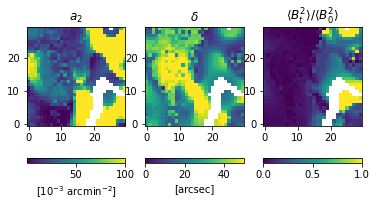

In [73]:
a2_map = res2['a']*3600*1000 # Units of 10^{-3} arcmin^{-2}
delta_map = res2['d'] # arcsec
ratio_map = Delta_p/res2['f']
plt.figure(figsize=(20,5))
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,nrows=1)
g = ax1.imshow(a2_map,origin='lower',vmin=1.,vmax=100.)
plt.colorbar(g,ax=ax1,orientation='horizontal',label=r'[10$^{-3}$ arcmin$^{-2}$]')
ax1.set_title(r'$a_{2}$')
g = ax2.imshow(delta_map,origin='lower',vmin=0.,vmax=50.)
plt.colorbar(g,ax=ax2,orientation='horizontal', label='[arcsec]')
ax2.set_title(r'$\delta$')
g = ax3.imshow(ratio_map,origin='lower',vmin=0.,vmax=1.)
plt.colorbar(g,ax=ax3,orientation='horizontal',label='')
bratio = r'$\langle B_{t}^{2}\rangle/\langle B_{0}^{2}\rangle$'
ax3.set_title(bratio)

The MCMC solver sometimes provides solutions for pixels that are out-of-statistics for their inmediate region. See for example the value ~100 in the $\a_{2}$ around the pixel (10,15). Therefore, we can "clean" the maps by performing a $\sigma$ clipping. That is, each pixel value is compared to the statistics in a 3x3 pixels kernel aroudn it. If the value is outside the range $median \pm n\sigma$ then the value for the such pixel is interpolated from its nearest neighbors.

In this case we choose $n=2$,

In [74]:
c_a2_map = utils.clean_map(a2_map,sigma=2,w=3)
c_delta_map = utils.clean_map(delta_map,sigma=2,w=3)
c_ratio_map = utils.clean_map(ratio_map,sigma=2,w=3)

And visualize the "clean" maps,

Text(0.5, 0.98, 'Clean Maps')

<Figure size 1440x360 with 0 Axes>

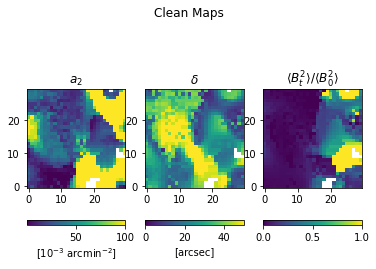

In [75]:
plt.figure(figsize=(20,5))
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,nrows=1)
g = ax1.imshow(c_a2_map,origin='lower',vmin=1.,vmax=100.)
plt.colorbar(g,ax=ax1,orientation='horizontal',label=r'[10$^{-3}$ arcmin$^{-2}$]')
ax1.set_title(r'$a_{2}$')
g = ax2.imshow(c_delta_map,origin='lower',vmin=0.,vmax=50.)
plt.colorbar(g,ax=ax2,orientation='horizontal', label='[arcsec]')
ax2.set_title(r'$\delta$')
g = ax3.imshow(c_ratio_map,origin='lower',vmin=0.,vmax=1.)
plt.colorbar(g,ax=ax3,orientation='horizontal',label='')
bratio = r'$\langle B_{t}^{2}\rangle/\langle B_{0}^{2}\rangle$'
ax3.set_title(bratio)
fig.suptitle('Clean Maps')

We see in these clean maps that the large value in the middle of the $a_{2}$ map dissapeared. The overall spatial distribution of the maps appears "smoother". However, changing the value of $\sigma$ or $w$ can help make these maps even smoother.

We now save these maps into a pickle file for using in Tutorial V where we will use the $bratio$ map for computing a map of $B_{\rm POS}$ using the DCF approximations,

In [34]:
res3 = {'a2_map':c_a2_map,'delta_map':c_delta_map,'ratio_map':c_ratio_map}
import pickle
pickle.dump(res3,open(cdir+'/data/disp_analysis_maps.pk',"wb"))